# Natural Language Processing with Disaster Tweets (Baseline)

This notebook is based on the [Fast.AI lesson 4](https://forums.fast.ai/t/lesson-4-official-topic/96441): I am transferring the approach from Jeremy's notebook "[Getting started with NLP for absolute beginners](https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners)" to the Kaggle competition "[Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started)".

The approach is the following: Classifying patent phrases or tweets is essentially "the same" task. In this first iteration, I just took the tweets as input (keeping it simple), and trained a Hugging Face transformers model to classify the tweets as disasters or not.

Many things could be improved in the training approach, but the goal of this notebook is not to create a perfect submission, but to create a baseline and to understand the concepts presented in lesson 4. For further optimization, please check [my other notebook on this competition](https://www.kaggle.com/code/christianwittmann/nlp-with-disaster-tweets-january-2023). 

## Preparing the notebook

For the real action in NLP, simply skip over this section. ;)

### Activating the GPU

I mention it, not to forget, and because this is the first time I am writing a complete notebook on Kaggle: Do not forget to activate the GPU:

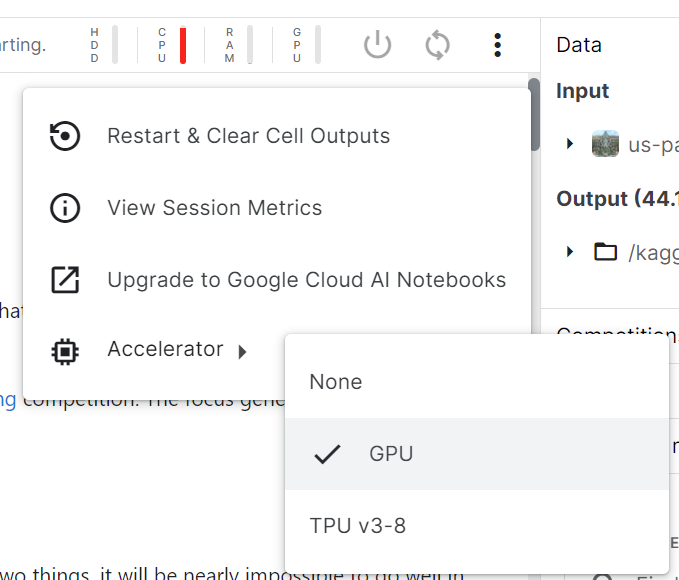

### Downloading the Competition Data

Maybe this is too obvious, but it took me a while to figure out: When you are on Kaggle, you do not download the data via the API in the notebook, but you can simply click on the "Add Data"-button on the top-right... (or is there a more elegant way to do this in the notebook without copy&pasting your credentials into the notebook?)

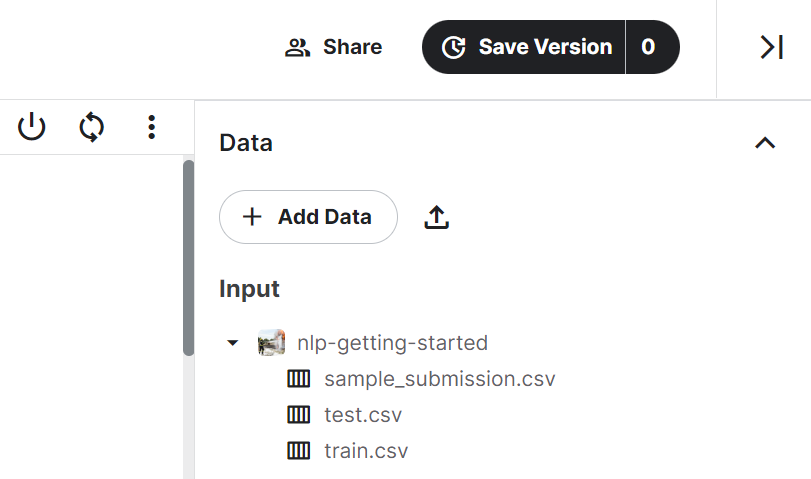

In [1]:
#saving the API calls for a potential non-kaggle-version of this notebook
#!kaggle competitions download -c nlp-getting-started
#!unzip nlp-getting-started.zip

In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
iskaggle

'Batch'

After having downloaded the data into the Kaggle space, you can access it by adding `../input/` in front of the path/competition name, in our case, the competition name is `nlp-getting-started`, therefore the path is `../input/nlp-getting-started`:

In [3]:
from pathlib import Path

if iskaggle:
    path = Path('../input/nlp-getting-started')
    ! pip install -q datasets

In [4]:
path

PosixPath('../input/nlp-getting-started')

In [5]:
!ls {path}

sample_submission.csv  test.csv  train.csv


### Installing packages in Kaggle

In [6]:
if iskaggle:
    ! pip install -q datasets #from Huggingface

### Installating packages on a local machine (not relevant right now, but saving what I did)

```bash
pip install datasets -U
pip install transformers -U
```


Install protobuf:

https://github.com/protocolbuffers/protobuf/tree/main/python#installation

https://www.geeksforgeeks.org/how-to-install-protobuf-on-ubuntu/ (not sure if this was needed)


```bash
sudo apt update
sudo apt upgrade
sudo apt install protobuf-compiler
protoc
```

https://forums.fast.ai/t/lesson-4-official-topic/96441/131:
```bash
pip install protobuf
pip install -U protobuf==3.19.0
```

## Inspecting the Data

In [7]:
import pandas as pd

train = pd.read_csv(path/"train.csv")
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


When starting the `trainer` (a couple of cells down) I got the error message `RuntimeError: "mse_cuda" not implemented for 'Long'`

As it turned out, this was a type problem: The field `target` needs to be a `float`, not an `int`. Fixing this in the dataframe:

In [9]:
train.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [10]:
train['target'] = train['target'].astype(float)

In [11]:
train.dtypes

id            int64
keyword      object
location     object
text         object
target      float64
dtype: object

In [12]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0


In [13]:
train.describe(include='object')

,keyword,location,text
count,7552,5080,7613
unique,221,3341,7503
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...
freq,45,104,10


As the model expects the input to be named `input`, let's rename it:

In [14]:
train['input'] = train.text

In [15]:
train.input.head()

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: input, dtype: object

## Preparing the Dataset

As explained in the [lesson](https://youtu.be/toUgBQv1BT8?t=1884): Let's create a Hugging Face dataset.

> Note: [Pytorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) has a class called `Dataset` and [Hugging Face](https://huggingface.co/docs/datasets/index) has a class called `Dataset` and they're different things. As a quick detour: This is how it looks in the pytorch world:

```python
from torch.utils.data import Dataset
```

In [16]:
from datasets import Dataset,DatasetDict #-> Hugging Face

ds = Dataset.from_pandas(train)

In [17]:
ds

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'target', 'input'],
    num_rows: 7613
})

[`microsoft/deberta-v3-small`](https://huggingface.co/microsoft/deberta-v3-small) is the recommended model to use:

In [18]:
model_nm = 'microsoft/deberta-v3-small'

Let's do the tokenization:

In [19]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/578 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.7/site-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [20]:
def tok_func(x): return tokz(x["input"])

Parallel processing via the `map` function:

In [21]:
tok_ds = ds.map(tok_func, batched=True)

  0%|          | 0/8 [00:00<?, ?ba/s]

In [22]:
row = tok_ds[0]
row['input'], row['input_ids']

('Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 [1,
  581,
  65453,
  281,
  262,
  18037,
  265,
  291,
  953,
  117831,
  903,
  4924,
  17018,
  43632,
  381,
  305,
  2])

In [23]:
tokz.vocab['▁of']

265

In [24]:
tok_ds = tok_ds.rename_columns({'target':'labels'})

Finally, let's create the training and test set (the test set is actually the validation set):

In [25]:
##dds = DictionaryDataset
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5709
    })
    test: Dataset({
        features: ['id', 'keyword', 'location', 'text', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1904
    })
})

### Training the Model

Let's set up the `trainer`, which is similar to Fast.AI's `learner`.

In [26]:
from transformers import TrainingArguments,Trainer

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Trying out some parameter values, these ones worked better than the initial ones:

In [27]:
#bs = 128
bs = 256 #trying to go for more parallelization
#epochs = 4 #for first submission
epochs = 20 #train a little more

In [28]:
#lr = 8e-5 #-> loss was going up...
#lr = 1e-5 #-> result basically ok, loss 0.129382 after 4 epochs
lr = 5e-6 #-> submission 2,3,4 - best so far
#lr = 1e-6 #-> produced a worse result

In [29]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')

In [30]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz)#, compute_metrics=corr_d) -> ???

Downloading:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [31]:
trainer.train();

The following columns in the training set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text, keyword, location, input, id. If text, keyword, location, input, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5709
  Num Epochs = 20
  Instantaneous batch size per device = 256
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 460


Epoch,Training Loss,Validation Loss
1,No log,0.424017
2,No log,0.288358
3,No log,0.237539
4,No log,0.188635
5,No log,0.147129
6,No log,0.129469
7,No log,0.126222
8,No log,0.129594
9,No log,0.131509
10,No log,0.131591


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text, keyword, location, input, id. If text, keyword, location, input, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1904
  Batch size = 512
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text, keyword, location, input, id. If text, keyword, location, input, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1904
  Batch size = 512
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text, keyword, location, input, id. If text, keyw

## Predictions

After the training is done, let's load the test set and get the predictions.

In [32]:
eval_df = pd.read_csv(path/'test.csv')
eval_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Same as before, we just use the tweet texts as input.

In [33]:
eval_df['input'] = eval_df.text

In [34]:
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

In [35]:
preds = trainer.predict(eval_ds).predictions.astype(float)

The following columns in the test set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: text, keyword, location, input, id. If text, keyword, location, input, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3263
  Batch size = 512


In [36]:
preds[:20]

array([[0.96630859],
       [1.03613281],
       [1.06445312],
       [0.88427734],
       [1.06835938],
       [0.97167969],
       [0.16638184],
       [0.12634277],
       [0.12866211],
       [0.11248779],
       [0.11126709],
       [0.15026855],
       [0.12298584],
       [0.15087891],
       [0.13757324],
       [1.10058594],
       [0.05569458],
       [0.6015625 ],
       [0.09124756],
       [0.07476807]])

Let's visualize the results:

In [37]:
import matplotlib.pyplot as plt
import numpy as np

In [38]:
bins = np.arange (-0.1, 1.3, 0.1)

In [39]:
np.histogram(preds, bins=bins)

(array([  0, 724, 673, 249, 184,  93,  75, 114,  74, 105, 127, 474, 371]),
 array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,
         1. ,  1.1,  1.2]))

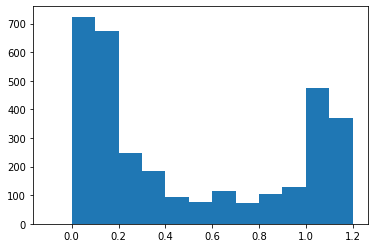

In [40]:
plt.hist(preds, bins=bins);

The model seems quite confident in telling us what is not a disaster, and we also observe a maximum around 1. It is, however, not so distinctive.
Let's try to simply round the preds to integers.

Before moving on, in the next cells, I have kept some results from other training runs with different parameters - I hope they show some improvements ;)

lr = 1e-5, epochs = 4

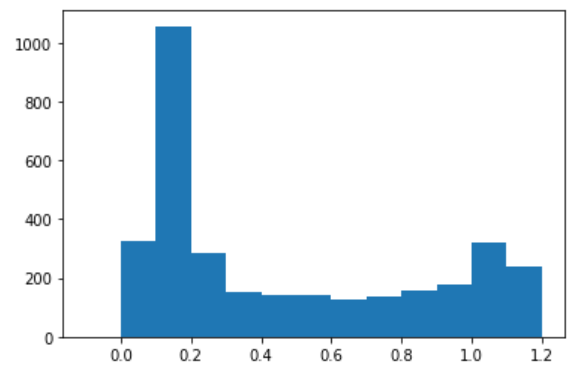

lr = 5e-6, epochs = 10

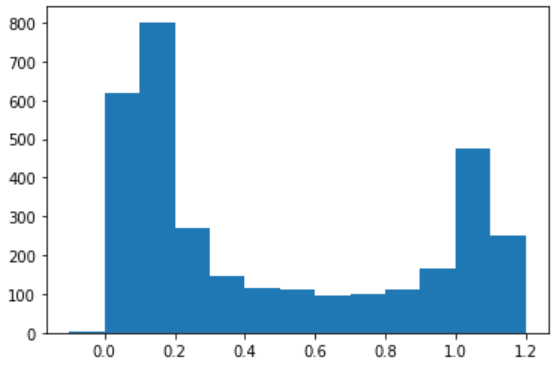

lr = 5e-6, epochs = 20, bs = 256

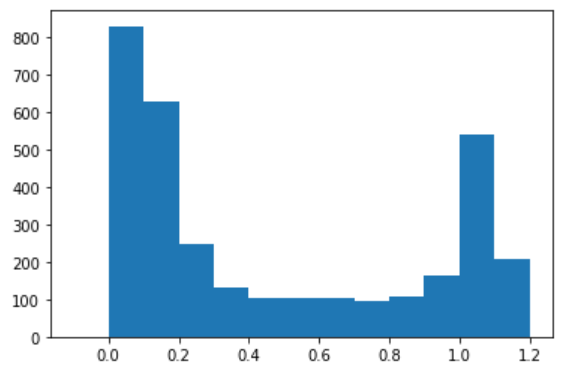

In [41]:
preds.round().astype(int)[:20]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0]])

In [42]:
preds = preds.round().astype(int).squeeze()

In [43]:
preds

array([1, 1, 1, ..., 1, 1, 1])

In [44]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'target': preds
})

submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

22746

## Competition Results

lr = 1e-5, epochs = 4

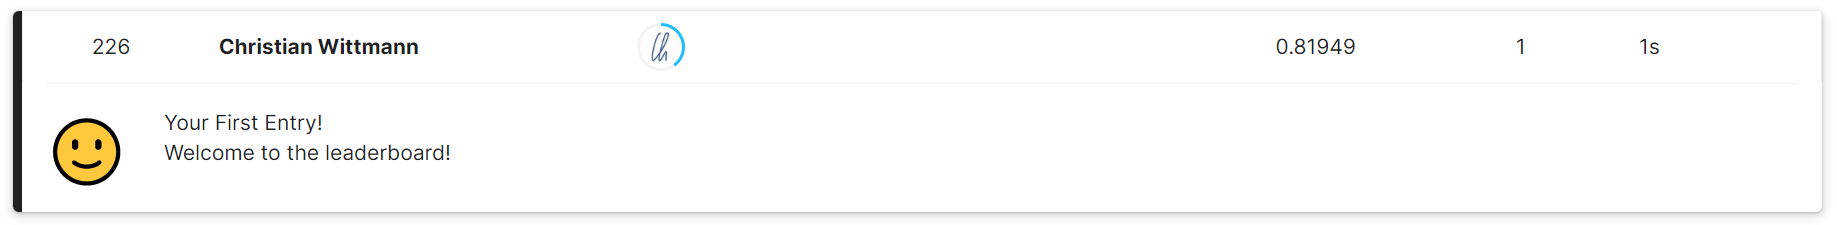

lr = 5e-6, epochs = 10

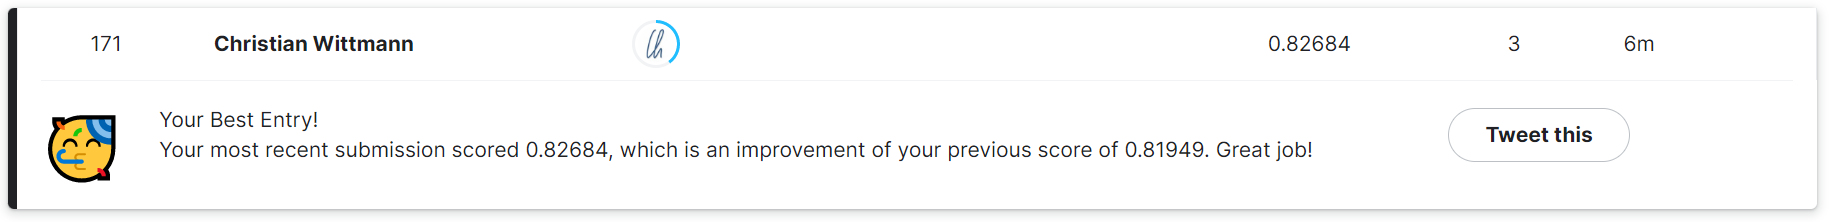

lr = 5e-6, epochs = 20, bs = 256

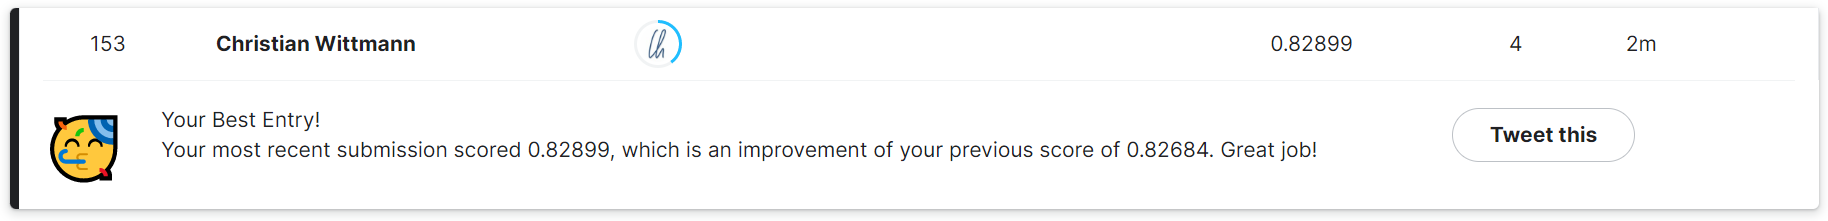